# Target
Comparison of standard PyTorch optimizers with various modifications of the new optimizer when training a simple neural network

## libraries

In [1]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import R2Score

# graphics
import matplotlib.pyplot as plt

# implementation
from tools import make_regression_data, RegressionDataset,\
                  standard_training, drem_opt_training, plot_results
from optimizers import DREMOptimizer

torch.random.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data

In [2]:
NUMBER_OF_FEATURES = 10
X_train, X_test, y_train, y_test = make_regression_data(number_samples=1000,
                                                        number_features=NUMBER_OF_FEATURES,
                                                        noise_value=5.5)
print(f'shape of train: {X_train.shape, y_train.shape}\nshape of test: {X_test.shape, y_test.shape}')

shape of train: (torch.Size([800, 10]), torch.Size([800, 1]))
shape of test: (torch.Size([200, 10]), torch.Size([200, 1]))


In [3]:
train_dataset = RegressionDataset(features=X_train,
                                  labels=y_train)
test_dataset = RegressionDataset(features=X_test,
                                 labels=y_test)
print(f'example of train sample:\n {train_dataset[19]}')

example of train sample:
 (tensor([-0.7738,  0.7570, -1.7787, -1.2447,  0.8696, -0.9222,  1.4960,  1.3556,
         1.8768,  0.4134]), tensor([10.8430]))


In [4]:
BATCH_SIZE = 50

train_dataloader = DataLoader(dataset=train_dataset,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE)
batch_example_features, batch_example_labels  = next(iter(train_dataloader))
print('shape of batch: features - {} and labels - {}'.format(batch_example_features.shape, batch_example_labels.shape))

shape of batch: features - torch.Size([50, 10]) and labels - torch.Size([50, 1])


## Optimizers & loss function & metric

In [5]:
loss_fn = nn.MSELoss()

metric_fn = R2Score()

## 1. Simple perceptron


## 1.1 Adam optimizer
Firstly, we train 1-layer perceptron with Adam optimizer (learning rate = 0.1) and try to achieve **R2-score=0.95**

In [6]:
simple_model = nn.Sequential(nn.Linear(in_features=10, out_features=1, bias=False))

# how many epochs we need to achieve 0.95 score?
n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                optimizer_fn=optim.Adam,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.1,
                                                                printed=True,
                                                                current_device=device)

epoch 1: loss = 16174.674 and score = 0.025
epoch 2: loss = 15345.459 and score = 0.075
epoch 3: loss = 14543.254 and score = 0.124
epoch 4: loss = 13796.152 and score = 0.169
epoch 5: loss = 13081.415 and score = 0.213
epoch 6: loss = 12404.828 and score = 0.254
epoch 7: loss = 11771.184 and score = 0.292
epoch 8: loss = 11151.865 and score = 0.329
epoch 9: loss = 10582.747 and score = 0.364
epoch 10: loss = 10006.848 and score = 0.398
epoch 11: loss = 9481.191 and score = 0.430
epoch 12: loss = 8974.008 and score = 0.461
epoch 13: loss = 8497.041 and score = 0.489
epoch 14: loss = 8051.910 and score = 0.516
epoch 15: loss = 7622.295 and score = 0.542
epoch 16: loss = 7212.104 and score = 0.567
epoch 17: loss = 6819.575 and score = 0.590
epoch 18: loss = 6443.269 and score = 0.613
epoch 19: loss = 6082.805 and score = 0.635
epoch 20: loss = 5747.888 and score = 0.655
epoch 21: loss = 5422.382 and score = 0.674
epoch 22: loss = 5115.359 and score = 0.693
epoch 23: loss = 4820.027 and s

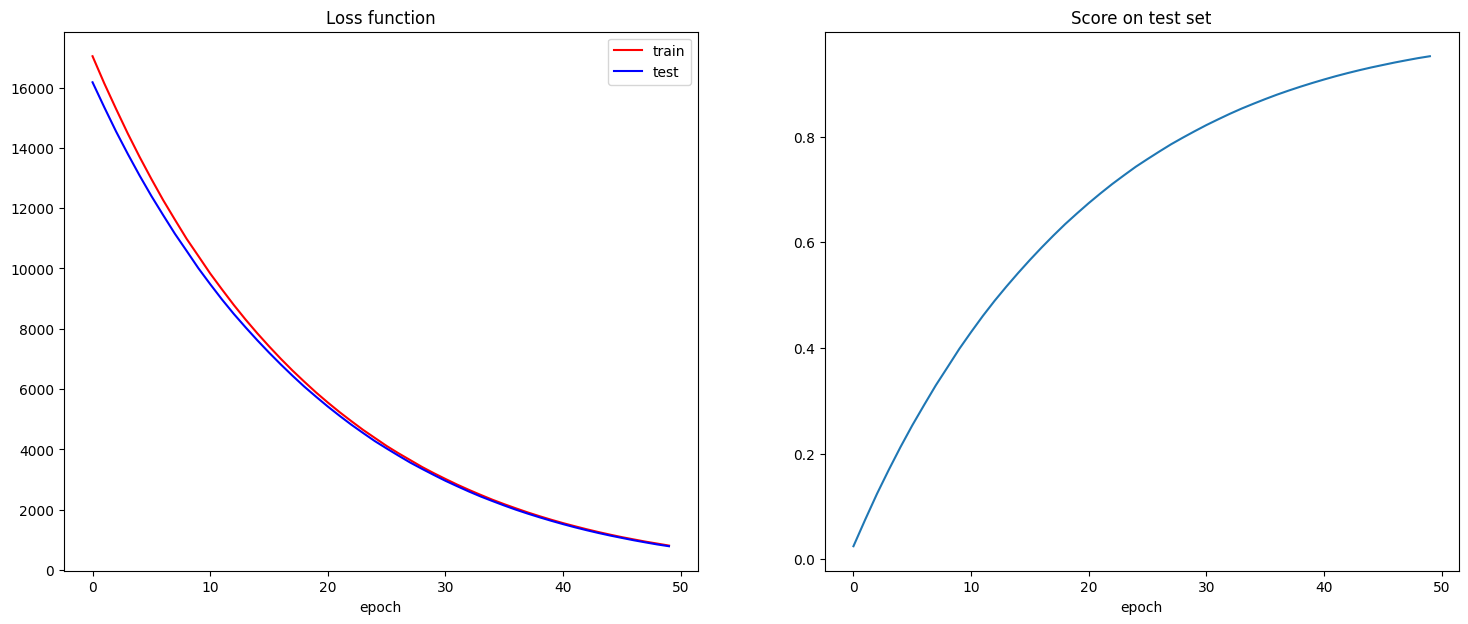

In [7]:
plot_results(train_loss, test_loss, test_score)

Secondly, we train 1-layer perceptron with Adam optimizer (learning rate = 0.1) **for 100 epochs**

In [8]:
simple_model = nn.Sequential(nn.Linear(in_features=10, out_features=1, bias=False))

train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                      optimizer_fn=optim.Adam,
                                                      loss_fn=loss_fn,
                                                      metric_fn=metric_fn,
                                                      data_train=train_dataloader,
                                                      data_test=test_dataloader,
                                                      learning_rate=0.1,
                                                      epochs=100,
                                                      current_device=device)

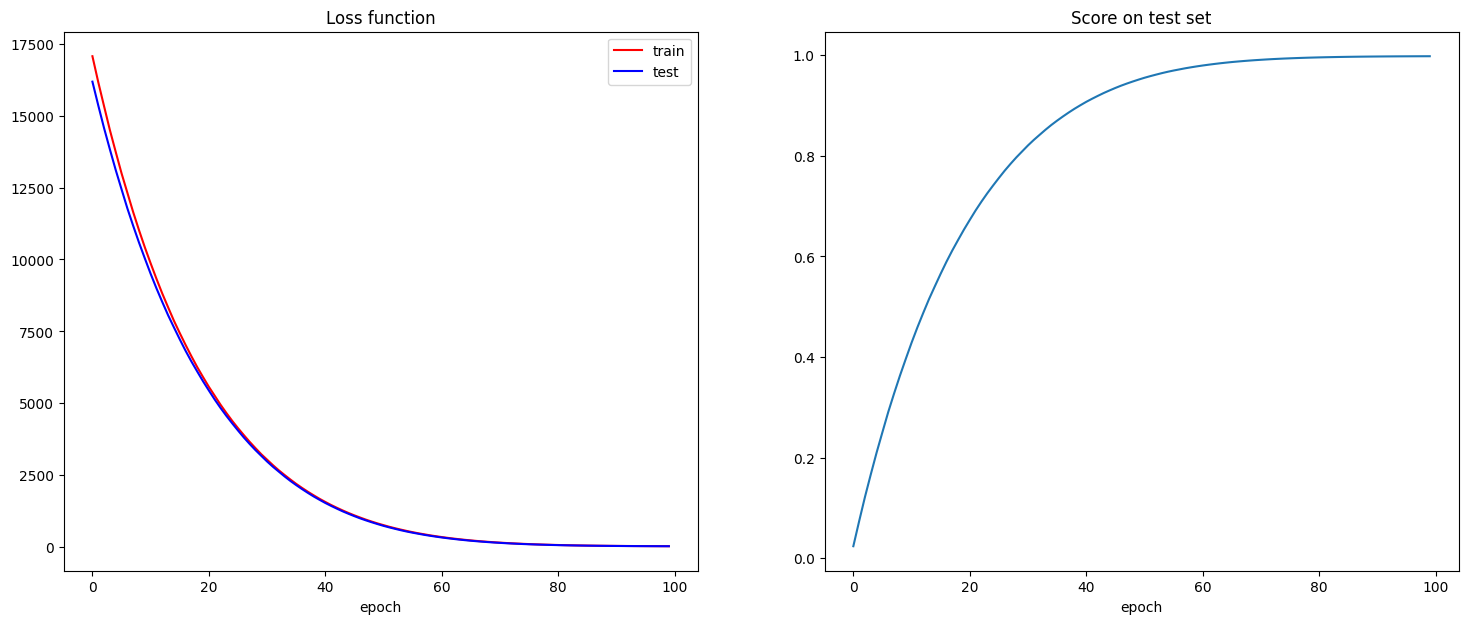

In [9]:
plot_results(train_loss, test_loss, test_score)

## 1.2 SGD optimizer
Train 1-layer perceptron with SGD optimizer (learning rate = 0.01) and try to achieve **R2-score=0.95**

In [10]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

# how many epochs we need to achieve 0.95 score?
n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                optimizer_fn=optim.SGD,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.01,
                                                                printed=True,
                                                                current_device=device)

epoch 1: loss = 9098.532 and score = 0.451
epoch 2: loss = 4888.548 and score = 0.705
epoch 3: loss = 2645.462 and score = 0.840
epoch 4: loss = 1442.909 and score = 0.913
epoch 5: loss = 795.165 and score = 0.952


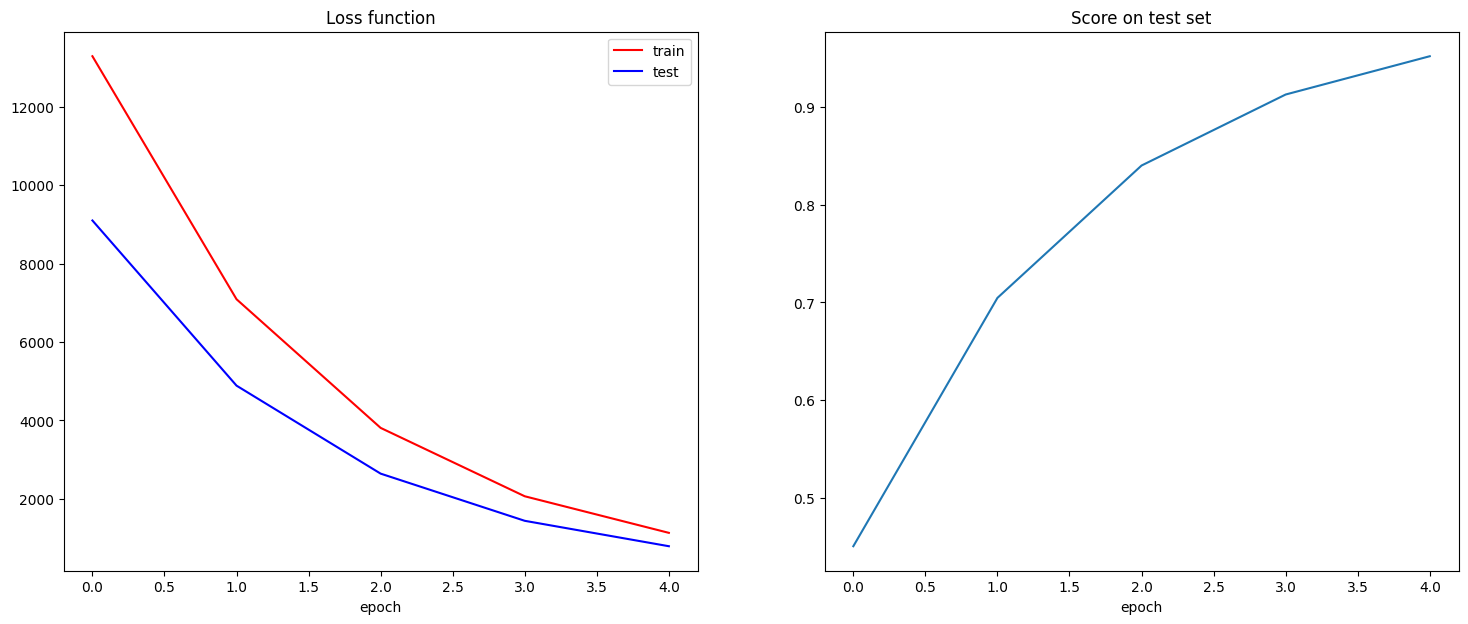

In [11]:
plot_results(train_loss, test_loss, test_score)

Train 1-layer perceptron with SGD optimizer (learning rate = 0.01) **for 100 epochs**

In [12]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                      optimizer_fn=optim.SGD,
                                                      loss_fn=loss_fn,
                                                      metric_fn=metric_fn,
                                                      data_train=train_dataloader,
                                                      data_test=test_dataloader,
                                                      learning_rate=0.01,
                                                      epochs=100,
                                                      current_device=device)

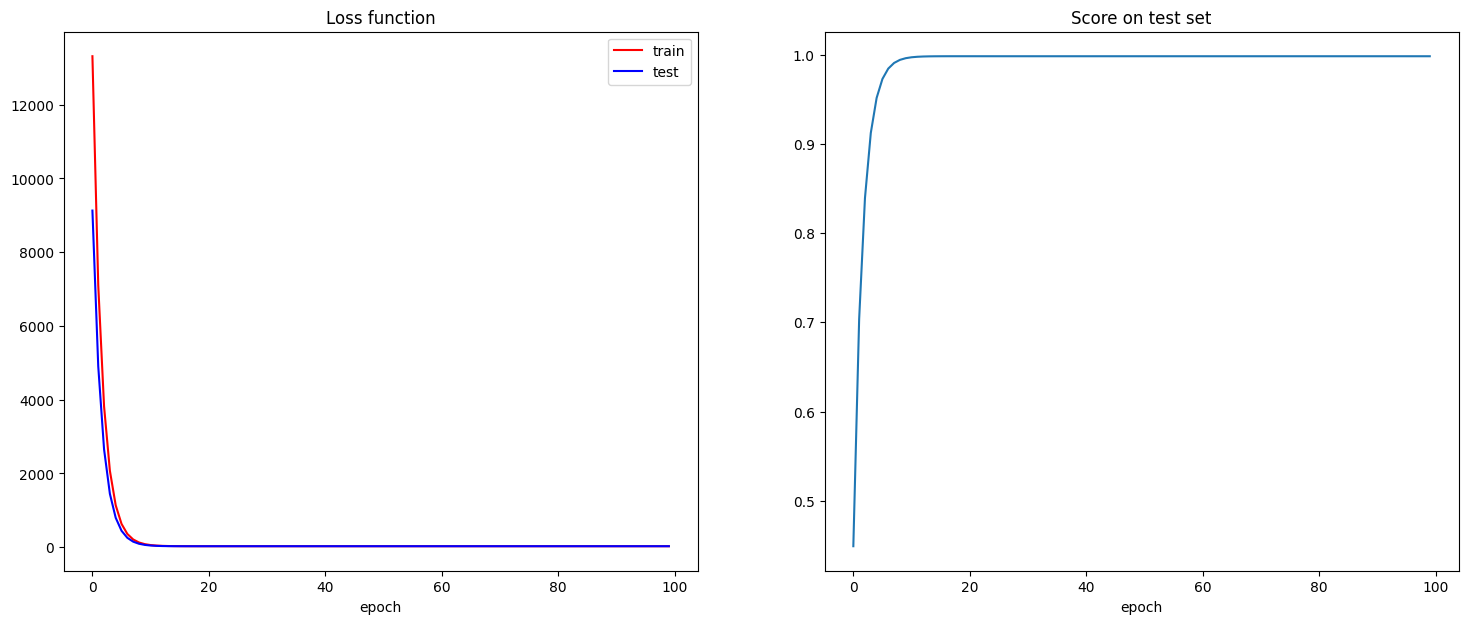

In [13]:
plot_results(train_loss, test_loss, test_score)

## 1.3 DREM optimizer
Train 1-layer perceptron with DREM optimizer (learning rate = 0.01) and try to achieve **R2-score=0.95**

In [14]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

n_epochs, train_loss, test_loss, test_score = drem_opt_training(model=simple_model,
                                                                optimizer_fn=DREMOptimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.01,
                                                                printed=True,
                                                                current_device=device)

epoch 1: loss = 3038.054 and score = 0.818
epoch 2: loss = 665.272 and score = 0.960


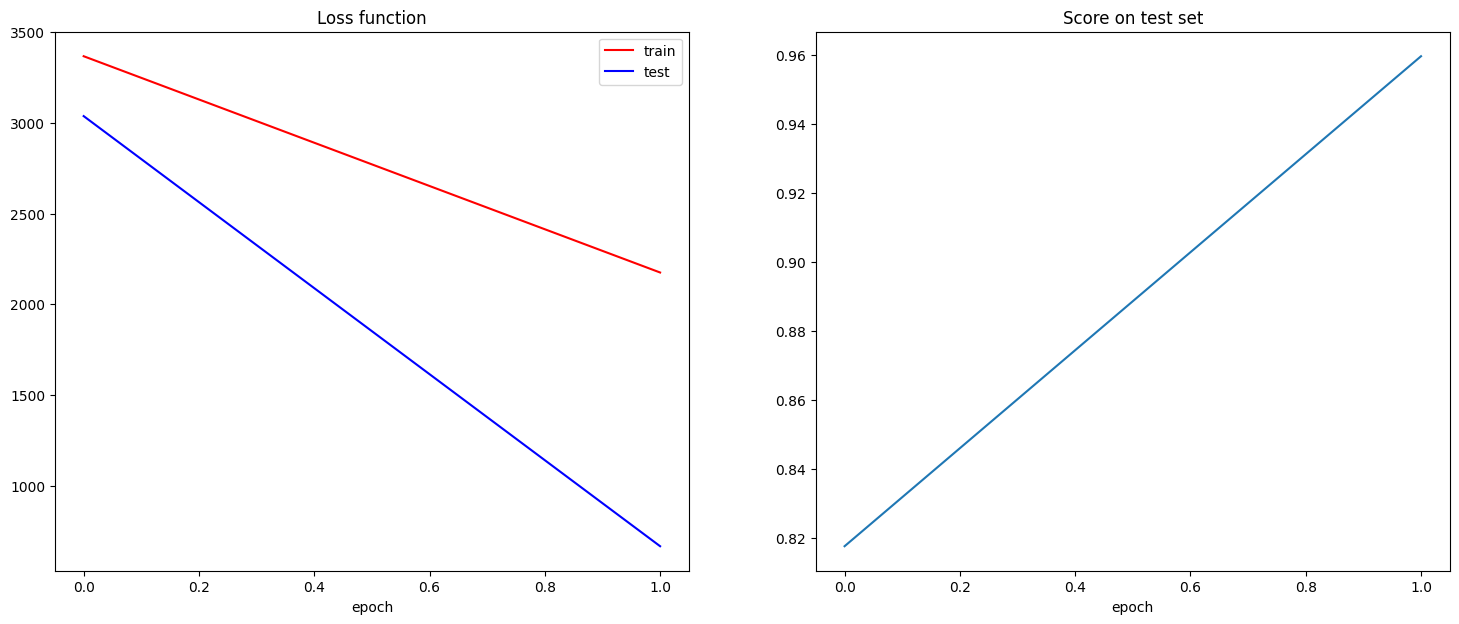

In [15]:
plot_results(train_loss, test_loss, test_score)

Train 1-layer perceptron with DREM optimizer (learning rate = 0.01) **for 100 epochs**

In [16]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

train_loss, test_loss, test_score = drem_opt_training(model=simple_model,
                                                      optimizer_fn=DREMOptimizer,
                                                      loss_fn=loss_fn,
                                                      metric_fn=metric_fn,
                                                      data_train=train_dataloader,
                                                      data_test=test_dataloader,
                                                      learning_rate=0.01,
                                                      epochs=100,
                                                      current_device=device)

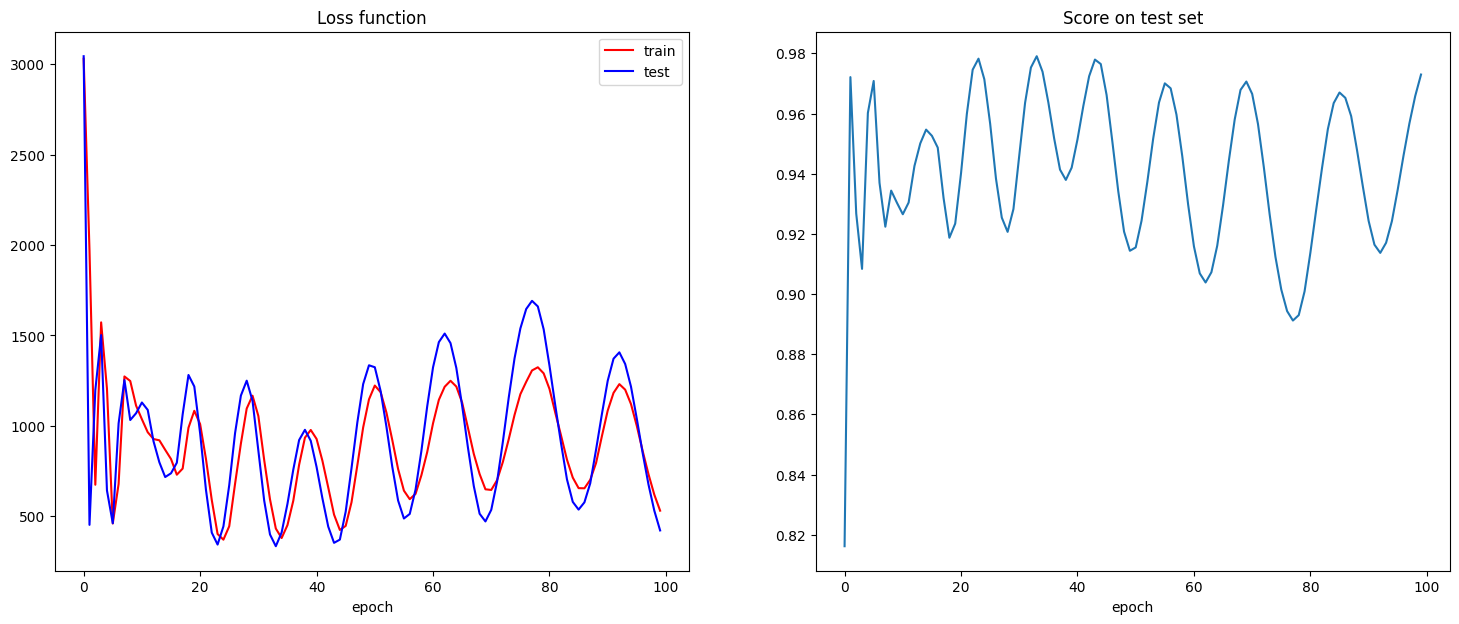

In [17]:
plot_results(train_loss, test_loss, test_score)

## 2. Non-classic MSE (loss function) with classic optimizers
At this topic we try to use non-classic MSE loss function (see image below) when training a simple model


![new loss](../report/new_loss.png)

To use it feature we need to change BATCH_SIZE (should be equal to number of neurons in the first layer)

In [18]:
train_dataloader = DataLoader(dataset=train_dataset,
                              shuffle=True,
                              batch_size=NUMBER_OF_FEATURES)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=NUMBER_OF_FEATURES)
batch_example_features, batch_example_labels  = next(iter(train_dataloader))
print('shape of batch: features - {} and labels - {}'.format(batch_example_features.shape, batch_example_labels.shape))

shape of batch: features - torch.Size([10, 10]) and labels - torch.Size([10, 1])


In [19]:
optimizers = [optim.Adam, optim.SGD, optim.Adagrad, optim.RMSprop]
learning_rates = [0.1, 1e-7, 100, 0.1]

In [20]:
for optimizer, lr in zip(optimizers, learning_rates):
    simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

    n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                    optimizer_fn=optimizer,
                                                                    loss_fn=loss_fn,
                                                                    metric_fn=metric_fn,
                                                                    data_train=train_dataloader,
                                                                    data_test=test_dataloader,
                                                                    learning_rate=lr,
                                                                    new_loss=True,
                                                                    current_device=device)
    print(f'{optimizer.__name__} need {n_epochs} epochs to achieve R2-score = {test_score[-1]:.3f}')

Adam need 47 epochs to achieve R2-score = 0.958
SGD need 1 epochs to achieve R2-score = 0.990
Adagrad need 1 epochs to achieve R2-score = 0.983
RMSprop need 28 epochs to achieve R2-score = 0.958


Also we can check how many epochs need new optimizer for this task (note: we change batch size)

In [21]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

n_epochs, train_loss, test_loss, test_score = drem_opt_training(model=simple_model,
                                                                optimizer_fn=DREMOptimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.01,
                                                                printed=True,
                                                                current_device=device)
print(f'DREM optimizer need {n_epochs} epochs to achieve R2-score = {test_score[-1]:.3f}')

epoch 1: loss = 540.595 and score = 0.958
DREM optimizer need 1 epochs to achieve R2-score = 0.958


## 3. More complex model
At this topic we try to train more complex model


## 3.1 Adam

In [22]:
simple_model = nn.Sequential(
    nn.Linear(in_features=10, out_features=15),
    nn.ELU(),
    nn.Linear(in_features=15, out_features=1),
)

n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                optimizer_fn=optim.Adam,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.1,
                                                                printed=True,
                                                                current_device=device)

print()
print(f'Adam need {n_epochs} epochs for {test_score[-1]:.3f} score')

epoch 1: loss = 336.924 and score = 0.975

Adam need 1 epochs for 0.975 score


## 3.2 SGD

In [23]:
simple_model = nn.Sequential(
    nn.Linear(in_features=10, out_features=15),
    nn.ELU(),
    nn.Linear(in_features=15, out_features=1),
)

n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                optimizer_fn=optim.SGD,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.001,
                                                                printed=True,
                                                                current_device=device)

print()
print(f'SGD need {n_epochs} epochs for {test_score[-1]:.3f} score')

epoch 1: loss = 337.132 and score = 0.975

SGD need 1 epochs for 0.975 score


## 3.3 DREM optimizer

In [24]:
simple_model = nn.Sequential(
    nn.Linear(in_features=10, out_features=15, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=15, out_features=1, bias=False),
)

n_epochs, train_loss, test_loss, test_score = drem_opt_training(model=simple_model,
                                                                optimizer_fn=DREMOptimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=1e-10,
                                                                printed=True,
                                                                current_device=device)

print()
print(f'New optimizer need {n_epochs} epochs for {test_score[-1]:.3f} score')

epoch 1: loss = 17078.787 and score = -0.112
epoch 2: loss = 16630.543 and score = -0.083
epoch 3: loss = 14669.127 and score = 0.045
epoch 4: loss = 14321.086 and score = 0.067
epoch 5: loss = 9573.313 and score = 0.377
epoch 6: loss = 8071.932 and score = 0.474
epoch 7: loss = 7098.229 and score = 0.521
epoch 8: loss = 5616.969 and score = 0.627
epoch 9: loss = 4378.875 and score = 0.713
epoch 10: loss = 3627.740 and score = 0.764
epoch 11: loss = 2047.824 and score = 0.864
epoch 12: loss = 824.536 and score = 0.940
epoch 13: loss = 1594.281 and score = 0.887
epoch 14: loss = 875.449 and score = 0.937
epoch 15: loss = 3263.373 and score = 0.785
epoch 16: loss = 2499.512 and score = 0.839
epoch 17: loss = 1581.993 and score = 0.891
epoch 18: loss = 914.151 and score = 0.936
epoch 19: loss = 1085.556 and score = 0.922
epoch 20: loss = nan and score = nan

New optimizer need 20 epochs for nan score
